In [65]:
# 1.0 Call libraries
# 1.1 Data manipulation libraries
import numpy as np
import pandas as pd

# 1.2 sklearn libraries
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# 1.3 For plotting NN model
#  conda install -c anaconda graphviz
#  conda install -c anaconda pydot
from skimage import io
import pydot

# 1.4 Keras model components
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# 1.4.1 For text (word) to integer transformation
from tensorflow.keras.preprocessing.text import Tokenizer

# 1.4.2 For making all integer sequences of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1.4.3 Import backend to invoke tensorflow commands to manipulate tensors
from tensorflow.keras import backend as K

# 1.5 Plotting libraries
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# 1.6 Misc
import math, time, os,gc

In [2]:
from google.colab import drive
drive.mount('/gdrive')  

Mounted at /gdrive


In [66]:
data = pd.read_csv("/gdrive/MyDrive/FA_Term_Project_Predictive/justice.csv") 

In [105]:
data.head()

,facts,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area,seq_facts
0,"In 1970, Jane Roe (a fictional name used in co...",7,2,1,5,2,2,"[7, 1586, 3049, 4127, 5, 9266, 844, 196, 7, 8,..."
1,Joan Stanley had three children with Peter Sta...,5,2,1,5,5,1,"[9267, 3052, 17, 123, 450, 18, 2932, 3052, 1, ..."
2,John Giglio was convicted of passing forged mo...,7,0,1,5,5,3,"[540, 9268, 10, 87, 2, 2840, 5096, 360, 1187, ..."
3,"The Idaho Probate Code specified that ""males m...",7,0,1,5,5,1,"[1, 2313, 4129, 371, 1643, 6, 5558, 212, 37, 7..."
4,"Miller, after conducting a mass mailing campai...",5,4,1,5,8,7,"[1080, 43, 2040, 5, 5561, 7827, 1129, 3, 6841,..."


In [106]:
data.columns

Index(['facts', 'majority_vote', 'minority_vote', 'first_party_winner',
       'decision_type', 'disposition', 'issue_area', 'seq_facts'],
      dtype='object')

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303 entries, 0 to 3302
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facts               3303 non-null   object
 1   majority_vote       3303 non-null   int64 
 2   minority_vote       3303 non-null   int64 
 3   first_party_winner  3303 non-null   int64 
 4   decision_type       3303 non-null   int64 
 5   disposition         3303 non-null   int64 
 6   issue_area          3303 non-null   int64 
 7   seq_facts           3303 non-null   object
dtypes: int64(6), object(2)
memory usage: 206.6+ KB


In [109]:
data.isnull().sum()

facts                 0
majority_vote         0
minority_vote         0
first_party_winner    0
decision_type         0
disposition           0
issue_area            0
seq_facts             0
dtype: int64

In [110]:
data.shape

(3303, 8)

In [111]:
data['issue_area'].mode()

0    2
dtype: int64

In [112]:
data['first_party_winner'].unique()

array([1, 0])

In [113]:
data['decision_type'].mode()

0    5
dtype: int64

In [69]:
#filling all the categorical null values with mode 
data['first_party_winner'] = data['first_party_winner'].fillna(data['first_party_winner'].mode()[0])
data['decision_type'] = data['decision_type'].fillna(data['decision_type'].mode()[0])
data['disposition'] = data['disposition'].fillna(data['disposition'].mode()[0])
data['issue_area'] = data['issue_area'].fillna(data['issue_area'].mode()[0])
data['first_party'] = data['first_party'].fillna("missing")
data['second_party'] = data['second_party'].fillna("missing")

In [70]:
data.isnull().sum()

Unnamed: 0            0
ID                    0
name                  0
href                  0
docket                0
term                  0
first_party           0
second_party          0
facts                 0
facts_len             0
majority_vote         0
minority_vote         0
first_party_winner    0
decision_type         0
disposition           0
issue_area            0
dtype: int64

In [71]:
data["issue_area"].value_counts()

Criminal Procedure      1001
Civil Rights             568
Economic Activity        542
First Amendment          353
Judicial Power           342
Due Process              128
Federalism               125
Privacy                   70
Unions                    60
Federal Taxation          51
Attorneys                 37
Miscellaneous             20
Private Action             4
Interstate Relations       2
Name: issue_area, dtype: int64

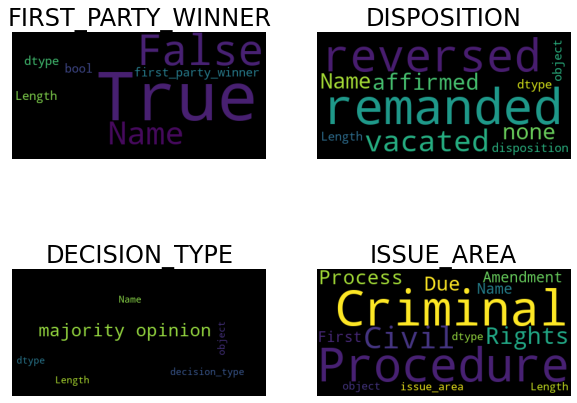

In [72]:
text_cols = ['first_party_winner', 'disposition', 'decision_type', 'issue_area']

from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state = 42)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(text_cols):
  op = wc.generate(str(data[c]))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(c.upper(), fontsize=24)
  _ = axes[i].axis('off')

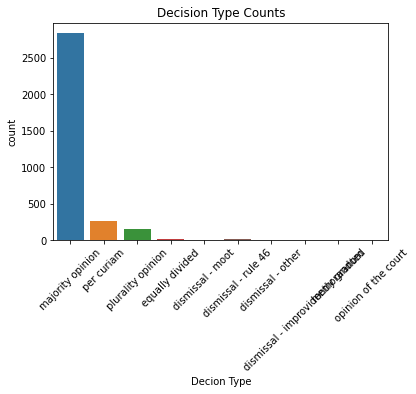

In [73]:
g=sns.countplot(x='decision_type',data=data)

g.set_xticklabels(g.get_xticklabels(),rotation=45) 
plt.title("Decision Type Counts")
plt.xlabel("Decion Type")
plt.show()

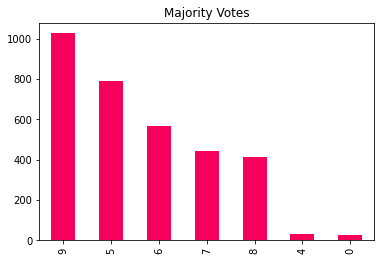

In [74]:
data["majority_vote"].value_counts().plot.bar(color='#f5005a', title='Majority Votes');

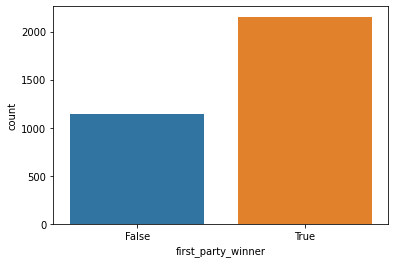

In [75]:
sns.countplot(x='first_party_winner',data=data)
plt.show()

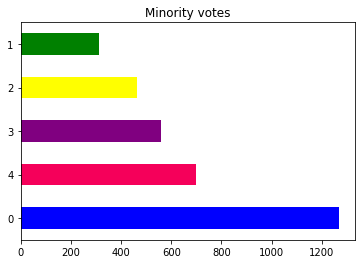

In [76]:
data["minority_vote"].value_counts().plot.barh(color=['blue', '#f5005a', 'purple', 'yellow', 'green'], title='Minority votes');

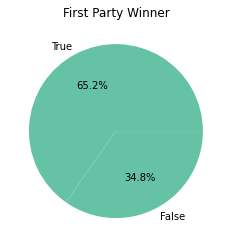

In [77]:
color = plt.cm.Set2(np.linspace(0,1,20))
data["first_party_winner"].value_counts().sort_values(ascending=False).head(20).plot.pie(y="term",colors=color,autopct="%0.1f%%")
plt.title("First Party Winner")
plt.axis("off")
plt.show()

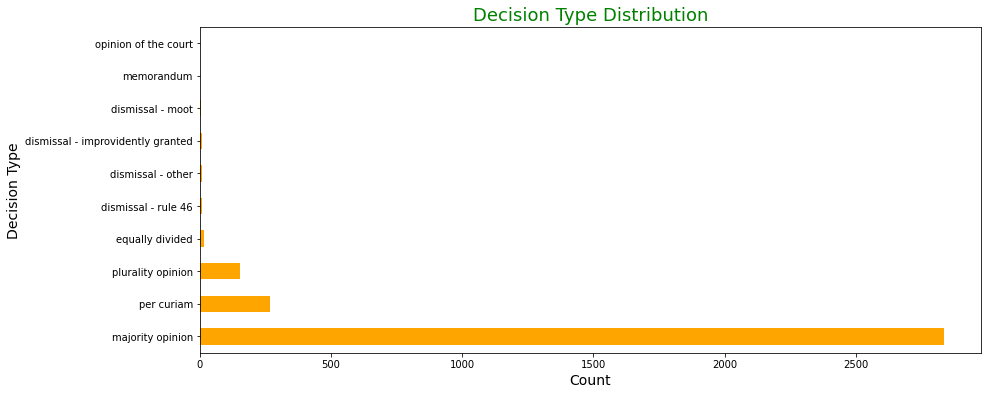

In [78]:
ax = data['decision_type'].value_counts().plot.barh(figsize=(14, 6), color='orange')
ax.set_title('Decision Type Distribution',color='green', size=18)
ax.set_ylabel('Decision Type', size=14)
ax.set_xlabel('Count', size=14);

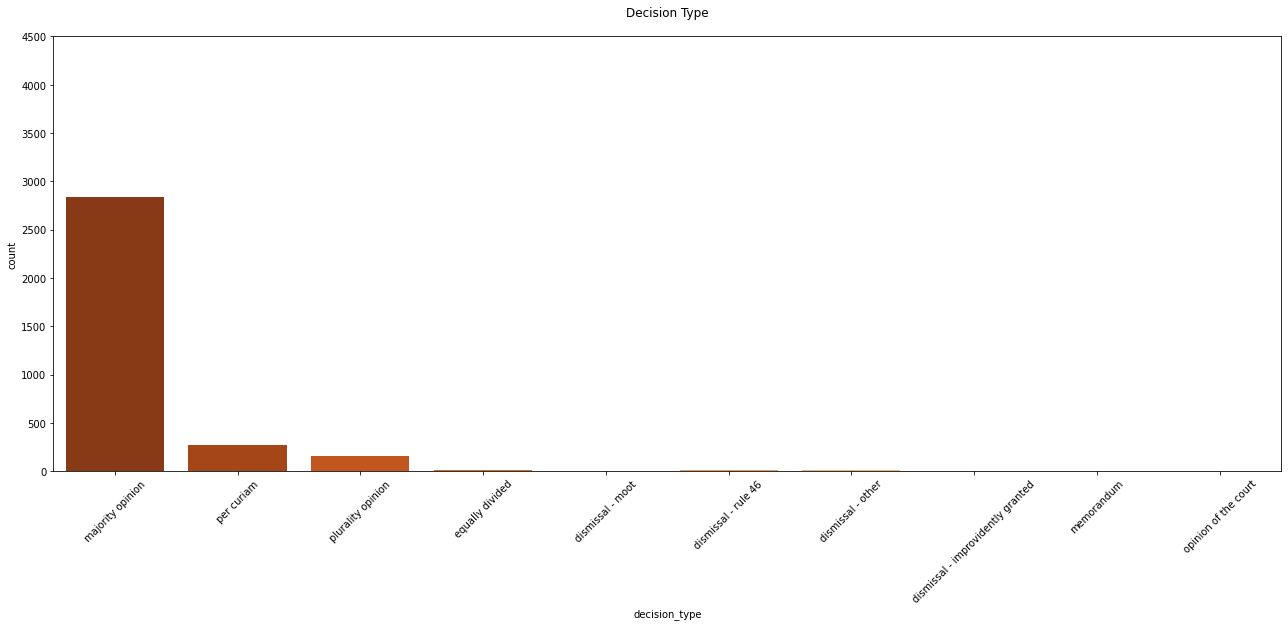

In [79]:
plt.figure(figsize = (22, 8))
ax = sns.countplot(data = data,
                   x = 'decision_type',
                   palette = 'Oranges_r')


ax.set_ylim(0, 4500)
ax.set_title('Decision Type', pad = 20)
plt.xticks(rotation=45)

plt.show()

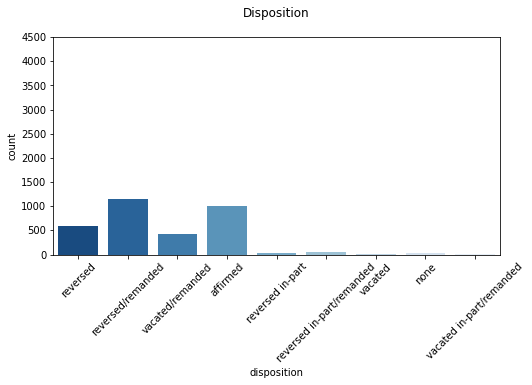

In [80]:
plt.figure(figsize = (8, 4))
ax = sns.countplot(data = data,
                   x = 'disposition',
                   palette = 'Blues_r')

ax.set_ylim(0, 4500)
ax.set_title('Disposition', pad = 20)
plt.xticks(rotation=45)

plt.show()

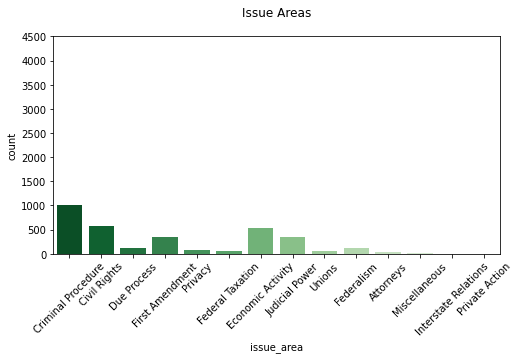

In [81]:
plt.figure(figsize = (8, 4))
ax = sns.countplot(data = data,
                   x = 'issue_area',
                   palette = 'Greens_r')

ax.set_ylim(0, 4500)
ax.set_title('Issue Areas', pad = 20)
plt.xticks(rotation=45)

plt.show()

In [82]:

import plotly.express as px

fig = px.bar(data[['issue_area','decision_type','first_party_winner']].sort_values('decision_type', ascending=False), 
                        y = "decision_type", x= "issue_area", color='first_party_winner', template='ggplot2')
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', color='crimson', size=14))
fig.update_layout(title_text="Issue Areas Decisions")

fig.show()

In [83]:
fig = px.bar(data[['decision_type','issue_area', 'disposition']].sort_values('issue_area', ascending=False), 
                        y = "issue_area", x= "decision_type", color='disposition', template='ggplot2')
fig.update_xaxes(tickangle=45, tickfont=dict(family='Rockwell', color='crimson', size=14))
fig.update_layout(title_text="Decisions Types by Issue Areas")

fig.show()

In [84]:
data['facts_len'].max()

6201

In [85]:
data['facts'] = data['facts'].str.replace(r'<[^<>]*>', '', regex=True)

In [86]:
raw_text = data['facts']

In [87]:
tok_raw = Tokenizer()           
tok_raw.fit_on_texts(raw_text)

In [88]:
tok_raw.word_index

{'the': 1,
 'of': 2,
 'to': 3,
 'and': 4,
 'a': 5,
 'that': 6,
 'in': 7,
 'court': 8,
 'for': 9,
 'was': 10,
 'on': 11,
 'district': 12,
 'not': 13,
 'his': 14,
 'by': 15,
 'an': 16,
 'had': 17,
 'with': 18,
 'appeals': 19,
 'state': 20,
 'as': 21,
 'federal': 22,
 'he': 23,
 'from': 24,
 'under': 25,
 'circuit': 26,
 's': 27,
 'it': 28,
 'u': 29,
 'which': 30,
 'act': 31,
 'were': 32,
 'or': 33,
 'because': 34,
 'held': 35,
 'supreme': 36,
 'be': 37,
 'at': 38,
 'trial': 39,
 'did': 40,
 'its': 41,
 'filed': 42,
 'after': 43,
 'affirmed': 44,
 'law': 45,
 'but': 46,
 'case': 47,
 'their': 48,
 'states': 49,
 'they': 50,
 'against': 51,
 'is': 52,
 'denied': 53,
 'found': 54,
 'this': 55,
 'argued': 56,
 'amendment': 57,
 'him': 58,
 'new': 59,
 'united': 60,
 'appeal': 61,
 'when': 62,
 'her': 63,
 'jury': 64,
 'violated': 65,
 'two': 66,
 'would': 67,
 'evidence': 68,
 'reversed': 69,
 'decision': 70,
 'other': 71,
 'granted': 72,
 'have': 73,
 'first': 74,
 'motion': 75,
 'claim': 7

In [89]:
MAX_FACT_VOC = len(tok_raw.word_index)

In [90]:
MAX_FACT_VOC

23690

In [91]:
data["seq_facts"] = tok_raw.texts_to_sequences(data.facts.values)

In [12]:
data.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area,seq_facts
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"In 1970, Jane Roe (a fictional name used in co...",501,7,2,True,majority opinion,reversed,Criminal Procedure,"[7, 1586, 3049, 4127, 5, 9266, 844, 196, 7, 8,..."
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,Joan Stanley had three children with Peter Sta...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights,"[9267, 3052, 17, 123, 450, 18, 2932, 3052, 1, ..."
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,John Giglio was convicted of passing forged mo...,495,7,0,True,majority opinion,reversed/remanded,Due Process,"[540, 9268, 10, 87, 2, 2840, 5096, 360, 1187, ..."
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"The Idaho Probate Code specified that ""males m...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights,"[1, 2313, 4129, 371, 1643, 6, 5558, 212, 37, 7..."
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"Miller, after conducting a mass mailing campai...",305,5,4,True,majority opinion,vacated/remanded,First Amendment,"[1080, 43, 2040, 5, 5561, 7827, 1129, 3, 6841,..."


In [92]:
data.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party','facts_len', 'term',"ID",'href'], inplace=True)

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303 entries, 0 to 3302
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facts               3303 non-null   object
 1   majority_vote       3303 non-null   int64 
 2   minority_vote       3303 non-null   int64 
 3   first_party_winner  3303 non-null   bool  
 4   decision_type       3303 non-null   object
 5   disposition         3303 non-null   object
 6   issue_area          3303 non-null   object
 7   seq_facts           3303 non-null   object
dtypes: bool(1), int64(2), object(5)
memory usage: 184.0+ KB


In [ ]:
cat = ['decision_type','disposition','issue_area']

In [94]:
le = LabelEncoder()
data['decision_type'] = le.fit_transform(data['decision_type'])

In [95]:
MAX_decision_type_VOC = len(le.classes_)
MAX_decision_type_VOC

10

In [96]:
le2 = LabelEncoder()
data['disposition'] = le2.fit_transform(data['disposition'])

In [97]:
MAX_disposition_VOC = len(le2.classes_)
MAX_disposition_VOC

9

In [98]:
le3 = LabelEncoder()
data['issue_area'] = le3.fit_transform(data['issue_area'])

In [99]:
le4 = LabelEncoder()
data['first_party_winner'] = le3.fit_transform(data['first_party_winner'])

In [100]:
MAX_issue_area_VOC = len(le3.classes_)
MAX_issue_area_VOC

2

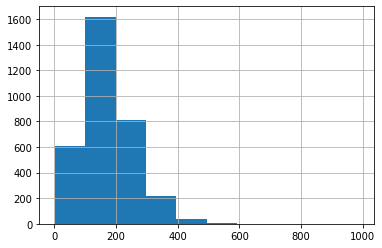

In [101]:
data.seq_facts.apply(lambda x: len(x)).hist()

In [102]:
def get_keras_data(dataset):
    X = {   
        'fact_in':           pad_sequences(data.seq_facts,
                                           maxlen=MAX_FACT_VOC      # 10
                                           ),                                                                                                                        # 2                                                # 3
        'decision_type_in':  data.decision_type.values,
        'issue_area_in': data.issue_area.values,
        'disposition_in': data.disposition.values,                                            # 5
        'num_vars_in': np.array(dataset[["majority_vote", "minority_vote"]])    # Two numeric columns here   # 6
    }
    return X

In [103]:
X_train = get_keras_data(data)

In [41]:
X = data.drop('first_party_winner',axis=1)
y=data['first_party_winner']

In [42]:
X_train,X_test, y_train, y_test = train_test_split(
                                                    X,                   # Data features
                                                    y,                   # Target column
                                                    test_size = 0.2      # split-ratio
                                                    )

In [43]:
X_train = get_keras_data(X_train)

In [ ]:
data['decision_type'].max()

9

In [ ]:
data['decision_type'].unique()

array([5, 8, 9, 4, 1, 3, 2, 0, 6, 7])

In [23]:
word2vec_size = 200   # For text column: seq_facts
cat2vec_size = 20    # For categorcal columns 

In [29]:
# FiVE Inputs. At each input specify number of input-features:

facts =            Input(shape=(X_train["fact_in"].shape[1]),      name="fact_in")           # Length of each sequence
decision_type =    Input(shape=(1,), name="decision_type_in")      # Length of each sequence
issue_area =      Input(shape=(1,),                             name="issue_area_in")     # Just 1 feature. Hence shape=[1]
disposition =   Input(shape=(1,),                             name="disposition_in")  # Just 1 feature. Hence shape=[1]
num_vars =        Input(shape=(X_train["num_vars_in"].shape[1]),  name="num_vars_in")

In [30]:
# Embedding layer
emb_name =           Embedding(MAX_FACT_VOC,      word2vec_size  )(facts)               
emb_decision_type =      Embedding(MAX_decision_type_VOC,      cat2vec_size )(decision_type)
emb_issue_area =     Embedding(MAX_issue_area_VOC,     cat2vec_size  )(issue_area)
emb_disposition =  Embedding(MAX_disposition_VOC,  cat2vec_size  )(disposition)

In [31]:
main_l = concatenate(
                        [
                          Flatten() (emb_decision_type),
                          Flatten() (emb_issue_area),
                          Flatten() (emb_disposition),
                          num_vars          # Feed numerical variables as they are
                        ]
                      )

In [32]:
main_l = Dense(128,activation='relu') (main_l)
main_l = Dense(64,activation='tanh') (main_l)

In [33]:
output = Dense(2, activation="sigmoid") (main_l)

In [34]:
model = Model(
              inputs= [                     
                        facts,
                        decision_type,
                        issue_area,
                        disposition,
                        num_vars
                       ],
              outputs= output
              )

In [35]:
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mae"]    # Not using rmsle_cust
              )

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decision_type_in (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 issue_area_in (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 disposition_in (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 20)        200         ['decision_type_in[0][0]']       
                                                                                              

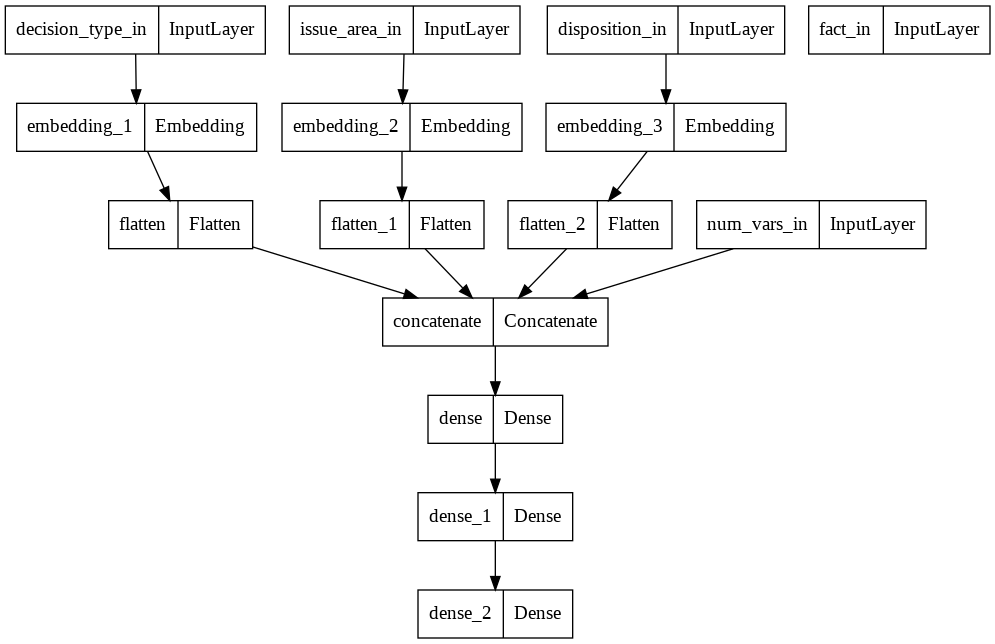

In [114]:
plot_model(model)

In [37]:
BATCH_SIZE = 250
epochs = 10

In [59]:
X = data.drop('first_party_winner',axis=1)
y=data['first_party_winner']


In [60]:
y[:5]

0    1
1    1
2    1
3    1
4    1
Name: first_party_winner, dtype: int64

In [61]:
X_train,X_test, y_train, y_test = train_test_split(
                                                    X,                   # Data features
                                                    y,                   # Target column
                                                    test_size = 0.2      # split-ratio
                                                    )

In [62]:
X_train = get_keras_data(X_train)

In [64]:
y_train[:5]

2805    0
2520    1
1364    0
2419    1
1706    0
Name: first_party_winner, dtype: int64

In [104]:
start = time.time()
history= model.fit(X_train,
                   data.first_party_winner,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
                   validation_split=0.2,
                   verbose=1
                  )

end = time.time()
print((end-start)/60)

Epoch 1/10
11/11 [==============================] - 0s 44ms/step - loss: 0.2226 - mae: 0.4425 - val_loss: 0.2165 - val_mae: 0.4376
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 0.2141 - mae: 0.4420 - val_loss: 0.2036 - val_mae: 0.4279
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.1924 - mae: 0.4145 - val_loss: 0.1691 - val_mae: 0.3954
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.1370 - mae: 0.3488 - val_loss: 0.0937 - val_mae: 0.2804
Epoch 5/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0636 - mae: 0.2028 - val_loss: 0.0504 - val_mae: 0.1338
Epoch 6/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0433 - mae: 0.0997 - val_loss: 0.0491 - val_mae: 0.0928
Epoch 7/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0420 - mae: 0.0808 - val_loss: 0.0507 - val_mae: 0.0910
Epoch 8/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0417 - m

In [ ]:
val_preds = model.predict(X_valid)

104/104 [==============================] - 1s 3ms/step


In [ ]:
preds = model.predict(X_valid, batch_size=BATCH_SIZE)

14/14 [==============================] - 0s 9ms/step
